<a href="https://colab.research.google.com/github/kteppris/RealWaste/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training von Deep Learning Modellen mit PyTorch Lightning

In unserem Projekt werden PyTorch, Torchvision und PyTorch Lightning als wichtige Werkzeuge für die Entwicklung und das Training der CNNs verwendet.

PyTorch ist ein flexibles und dynamisches Open-Source Deep-Learning-Framework, das von Forschern und Entwicklern aufgrund seiner Einfachheit und Effizienz geschätzt wird. Es bietet eine intuitive API, die es ermöglicht, komplexe neuronale Netzwerkarchitekturen einfach zu erstellen und zu trainieren. Die Flexibilität von PyTorch ermöglicht es, CNN-Modelle zu entwerfen und anzupassen, um sie an die spezifischen Anforderungen der Müllklassifizierungsaufgabe anzupassen. [The Linux Foundation 2024] (https://pytorch.org/)

Torchvision ist eine Bibliothek, die auf PyTorch aufbaut und speziell für Computer Vision-Anwendungen entwickelt wurde. Sie bietet eine Vielzahl von nützlichen Funktionen und Werkzeugen, darunter vortrainierte Modelle, Datensatz-Loader und Bildtransformationen. Torchvision wird in diesem Projekt genutzt, um auf vortrainierte CNN-Modelle wie Inception oder DenseNet zuzugreifen. Diese vortrainierten Modelle dienen als Ausgangspunkt für folgende Trainings und ermöglichen es, von bereits gelernten Merkmalen zu profitieren und somit die Trainings- und Rechenzeit zu verkürzen. So können bereits in wenigen Epochen hohe Klassifikationsgenauigkeiten erzielt werden. [The Linux Foundation 2024] (https://pytorch.org/vision/stable/index.html)

PyTorch Lightning ist ein Framework, das darauf abzielt, die Entwicklung von PyTorch-Modellen zu vereinfachen und zu standardisieren, indem es bewährte Praktiken und Designmuster fördert. Es bietet eine leichtgewichtige und modulare API, die es ermöglicht, Trainings- und Evaluierungsschleifen effizient zu organisieren und zu verwalten. Durch die Verwendung von PyTorch Lightning kann der Code strukturiert, wieder verwendbare Komponenten erstellt und das Training der CNN-Modelle skalierbarer und einfacher gemacht werden. [Lightning AI 2024] (https://lightning.ai/docs/pytorch/stable/)

- Setup der Pfade

In [7]:
import sys
from pathlib import Path

# Funktion, die prüft, ob dieses Skript in Colab ausgeführt wird
def in_colab():
    # sys beinhaltet alle bereits geladenen Pakete
    return 'google.colab' in sys.modules  # google.colab wird automatisch in Colab vorgeladen, daher Indiz für Colab Environment

code_repo_path = Path("/content/drive/MyDrive/MADS/RealWaste") if in_colab() else Path.cwd()

if in_colab():
    # Google Drive einbinden zum persistieren von Code, Daten und Ergebnissen
    from google.colab import drive
    drive.mount('/content/drive')
    if not code_repo_path.exists():
        raise FileNotFoundError("Code und Datenordner konnte nicht gefunden werden. Bitte zuerst das Notebook '1_Hauptnotebook.ipynb' ausführen.")
    else:
        # wechsle Arbeitsverzeichnis zu code_repo_path
        %cd {code_repo_path}
        print(f"Wechsel Arbeitsverzeichnis zu {Path.cwd()}")
        %pip install -r requirements.txt
else:
    print("Stellen Sie sicher, dass das richtige Venv als Kernel ausgewählt ist,\nwelches wie in '1_Hauptnotebook.ipynb' beschrieben erstellt wurde.")

data_path = code_repo_path / "data"

Stellen Sie sicher, dass das richtige Venv als Kernel ausgewählt ist,
welches wie in '1_Hauptnotebook.ipynb' beschrieben erstellt wurde.


## Base Datamodule

- Basis des Datenmodules, sodass später nurnoch transformationen angepasst werden müssen

In [8]:
from pytorch_lightning import LightningDataModule
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torch
import os
import numpy as np

class ConfigurableDataModule(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int, transform, workers=-1, seed=42):
        super().__init__()
        self.workers = os.cpu_count() if workers == -1 else workers
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform
        self.seed = seed

    def setup(self, stage=None):
        # Seed setzen für konsistenz
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

        # Datensatz Ordner erstellen mit Torchvisions Imagefolder
        full_dataset = ImageFolder(root=self.data_dir, transform=self.transform)

        # Aufteilen der Bilder in Train/Validation Datensatz mit gleicher Verteilung von Klassen
        train_indices, val_indices = self.stratified_split(full_dataset)

        # Datensätze setzen
        self.train_dataset = Subset(full_dataset, train_indices)
        self.val_dataset = Subset(full_dataset, val_indices)

    def stratified_split(self, dataset):
        # Label der einzelnen Datenpunkte erhalten
        targets = np.array([sample[1] for sample in dataset.samples])
        
        # Anzahl der jeweiligen Bilder pro Klasse berechnen
        _, class_counts = np.unique(targets, return_counts=True)
        train_counts = (class_counts * 0.8).astype(int)  
        val_counts = class_counts - train_counts 

        train_indices = []
        val_indices = []
        
        # Indizes der Bilder für Train/Val bestimmen
        for class_idx in range(len(class_counts)):
            indices = np.where(targets == class_idx)[0]
            np.random.shuffle(indices)  
            
            train_indices.extend(indices[:train_counts[class_idx]])
            val_indices.extend(indices[train_counts[class_idx]:])

        # Mischen der Indizes
        np.random.shuffle(train_indices)
        np.random.shuffle(val_indices)

        return train_indices, val_indices

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.workers)


## Base Lightning Module

- Basis für das Training und die individuellen Modelle

In [9]:
from PIL import ImageDraw
import pytorch_lightning as pl
import torch
import torchmetrics
import torchvision
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_tensor
import random
import time
import shutil
from pathlib import Path

class BaseWasteClassifier(pl.LightningModule):
    CLASS_NAMES = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

    def __init__(self, num_classes: int, results_dir="results"):
        super().__init__()
        self.num_classes = num_classes
        # Klassennamen bekommen, für den result Ordner namen
        model_class_name = self.__class__.__name__
        
        # Ergebnisspfade definieren
        self.results_dir = Path(results_dir) / model_class_name
        self.models_dir = self.results_dir / "models"
        self.images_dir = self.results_dir / "images"
        self.logs_dir = self.results_dir / "logs"

        # Pfade erstellen
        self.results_dir.mkdir(parents=True, exist_ok=True)
        self.models_dir.mkdir(parents=True, exist_ok=True)
        self.images_dir.mkdir(parents=True, exist_ok=True)
        self.logs_dir.mkdir(parents=True, exist_ok=True)

        # Platzhalter wo später das tatsächlich Modell hinkommt
        # Wird bei konkreten Klassen definiert
        self.model = None

        # Metrik tracker initialisieren
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro')
        self.precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='weighted')
        self.recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='weighted')
        self.f1_score = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='weighted')


    def forward(self, x):
        # Diese Method ist quasi "abstract" und muss von der jeweiligen konkreten Klasse definiert werden
        raise NotImplementedError("This method should be overridden by subclasses.")

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[0]  
        loss = torch.nn.functional.cross_entropy(logits, y)
        acc = self.accuracy(torch.argmax(logits, dim=1), y)
        precision = self.precision(torch.argmax(logits, dim=1), y)
        recall = self.recall(torch.argmax(logits, dim=1), y)
        f1 = self.f1_score(torch.argmax(logits, dim=1), y)  

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Log precision, recall, and F1 Score
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_start(self):
        self.clear_images_directory()

    def validation_step(self, batch, batch_idx):
        # Start Zeit zwischenspeichern
        start_time = time.perf_counter()  
        
        # batch in trainingsbilder und label teilen
        x, y = batch
        
        # Vorhersage Logits bekomm
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        
        #  Zeit steppen für Inferenz
        inference_time = time.perf_counter() - start_time
        
        # Berechnung der Metriken
        acc = self.accuracy(torch.argmax(logits, dim=1), y)
        precision = self.precision(torch.argmax(logits, dim=1), y)
        recall = self.recall(torch.argmax(logits, dim=1), y)
        f1 = self.f1_score(torch.argmax(logits, dim=1), y)
        
        # Logging
        self.log('val_inference_time', inference_time, prog_bar=True, logger=True)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        
        # Logits in Klassen Label umwandeln
        predictions = torch.argmax(logits, dim=1)  
        
        # Zufällig 10% der Validation Bilder mit Label beschriftet speichern
        if random.random() < 0.1:
            self.log_images_with_labels(x, y, predictions, batch_idx)
        return loss

    def log_images_with_labels(self, images, labels, predictions, batch_idx):
        annotated_images = []
        for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
            image = self.unnormalize(image)
            actual_class_name = self.CLASS_NAMES[label.item()]

            image_dir = self.images_dir / actual_class_name
            image_dir.mkdir(parents=True, exist_ok=True)

            # Bilder mit Label beschriften
            pil_img = F.to_pil_image(image)
            draw = ImageDraw.Draw(pil_img)
            annotation_text = f'Actual: {actual_class_name}, Predicted: {self.CLASS_NAMES[prediction.item()]}'
            draw.text((10, 10), annotation_text, fill="white")

            file_path = image_dir / f"epoch_{self.current_epoch}_batch_{batch_idx}_image_{i}.png"

            pil_img.save(file_path)

            annotated_img = to_tensor(pil_img)
            annotated_images.append(annotated_img.unsqueeze(0))

        # Image Matrix erstellen
        annotated_images_tensor = torch.cat(annotated_images, dim=0)
        img_grid = torchvision.utils.make_grid(annotated_images_tensor, nrow=4)

        self.logger.experiment.add_image(f'Validation Images, Batch {batch_idx}', img_grid, self.current_epoch)

    def clear_images_directory(self):
        # Bilderordner löschen
        if self.images_dir.exists() and self.images_dir.is_dir():
            for class_dir in self.images_dir.iterdir():
                if class_dir.is_dir():  
                    shutil.rmtree(class_dir)

    def unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        # normalisierung vom Anfang Rückgängig machen
        image = image.clone()  
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)  
        return image

    def configure_optimizers(self):
        # SGD, kann überschrieben werden wenn andere Optimizer gewünscht
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        return optimizer


## PyTorch Lightning Callbacks

- Funktion die checkpoint und early stop callback vorbereit
- Reduziert das laden dieser Callbacks for jedem Training zu einer Zeile Code

In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

def get_callbacks(model_checkpoint_path: str, early_stop_patience=2):
    callbacks = []

    # M
    checkpoint_callback = ModelCheckpoint(
        dirpath=model_checkpoint_path,
        filename='{epoch}-{val_loss:.2f}',
        save_top_k=2,  # Nur die besten zwei Modelle behalten
        verbose=True,
        monitor='val_loss',  # Metrik die beobachtet werden soll
        mode='min', # Niedrigere loss ist besser
    )
    callbacks.append(checkpoint_callback)

    # Stoppt des Training wenn sich val Metrik nicht verbessert
    early_stopping_callback = EarlyStopping(
        monitor="val_acc",  # Die Metrik beobachtet wird
        mode="max",  # Maximiert die Genauigkeit
        patience=early_stop_patience,  # "Wartet" 2 Epoche ohne Verbesserung
    )
    callbacks.append(early_stopping_callback)
    return callbacks



## Train Modell Funktion

- Initialisiert Logger
- Startet Training

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path  
sns.set()

def make_summary_plots(logs_dir):
    metrics_df = pd.read_csv(Path(logs_dir) / 'metrics.csv')

    #     # Nach Epoch gruppieren und aggregieren der Metriken
    agg_funcs = {col: 'last' for col in metrics_df.columns if 'epoch' in col or 'val_' in col}
    metrics_df = metrics_df.groupby('epoch', as_index=False).agg(agg_funcs)

    # Plots vorbereiten
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust to a single row with three columns
    fig.suptitle('Training and Validation Metrics Over Epochs')

    # Loss Funktionen 
    axs[0].plot(metrics_df['epoch'], metrics_df['train_loss_epoch'], label='Train Loss')
    axs[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_ylim(0, 2.0)  # Set y-axis range for loss
    axs[0].legend()

    # Accuracy Plot
    axs[1].plot(metrics_df['epoch'], metrics_df['train_acc_epoch'], label='Train Accuracy')
    axs[1].plot(metrics_df['epoch'], metrics_df['val_acc'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)  # Set y-axis range for percentage metrics
    axs[1].legend()

    # Precision, Recall, and F1 Score Plot
    axs[2].plot(metrics_df['epoch'], metrics_df['train_precision_epoch'], label='Train Precision')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_precision'], label='Validation Precision')
    axs[2].plot(metrics_df['epoch'], metrics_df['train_recall_epoch'], label='Train Recall')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_recall'], label='Validation Recall')
    axs[2].plot(metrics_df['epoch'], metrics_df['train_f1_epoch'], label='Train F1 Score')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_f1'], label='Validation F1 Score')
    axs[2].set_title('Precision, Recall & F1 Score')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Score')
    axs[2].set_ylim(0, 1)  # Set y-axis range for percentage metrics
    axs[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [22]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger


def train_model(model, data_module, tb_log_dir="results/tb_logs", max_epochs=50, logger_name="model_logs", callbacks=[]):
    # Logger definieren
    tb_logger = TensorBoardLogger(tb_log_dir, name=logger_name)
    csv_logger = CSVLogger(model.results_dir, name="logs")
    
    trainer = Trainer(max_epochs=max_epochs, logger=[tb_logger, csv_logger], callbacks=callbacks)
    trainer.fit(model, datamodule=data_module)

    make_summary_plots(csv_logger.log_dir)


In [23]:
%reload_ext tensorboard
%tensorboard --logdir={code_repo_path / "results/tb_logs"}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\Felix\anaconda3\envs\cudatest\Scripts\tensorboard-script.py", line 5, in <module>
    from tensorboard.main import run_main
  File "C:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "C:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\tensorboard\default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "C:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\tensorboard\plugins\audio\audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "C:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\tensorboard\plugin_util.py", line 20, in <module>
    from tensorboard._vendor.bleach.sanitizer import Cleaner
  File "C:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\tensorboard\_vendor\bleach\__i

## SimpleCNN

In [8]:
import torch.nn as nn

class SimpleCNN(BaseWasteClassifier):
    def __init__(self, num_classes=9, lr=1e-3):
        self.lr = 1e-3
        super().__init__(num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),  # Bestätigt, dass dies für eine Eingabegröße von 224x224 korrekt ist
            nn.ReLU(),
            nn.Dropout(0.5), # Overfitting vermeiden
            nn.Linear(512, num_classes) # lineare Schicht auf die Klassen
        )


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Train SimpleCNN

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: results/tb_logs/simple_CNN
2024-02-25 20:08:48.677569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 20:08:48.677614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 20:08:48.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 1.24018 (best 1.24018), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=0-val_loss=1.24.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 1.06254 (best 1.06254), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=1-val_loss=1.06.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.93359 (best 0.93359), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=2-val_loss=0.93.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.93658 (best 0.93359), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=3-val_loss=0.94.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.93198 (best 0.93198), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=4-val_loss=0.93.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1071: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1190: 'val_loss' was not in top 2
`Trainer.fit` stopped: `max_epochs=10` reached.


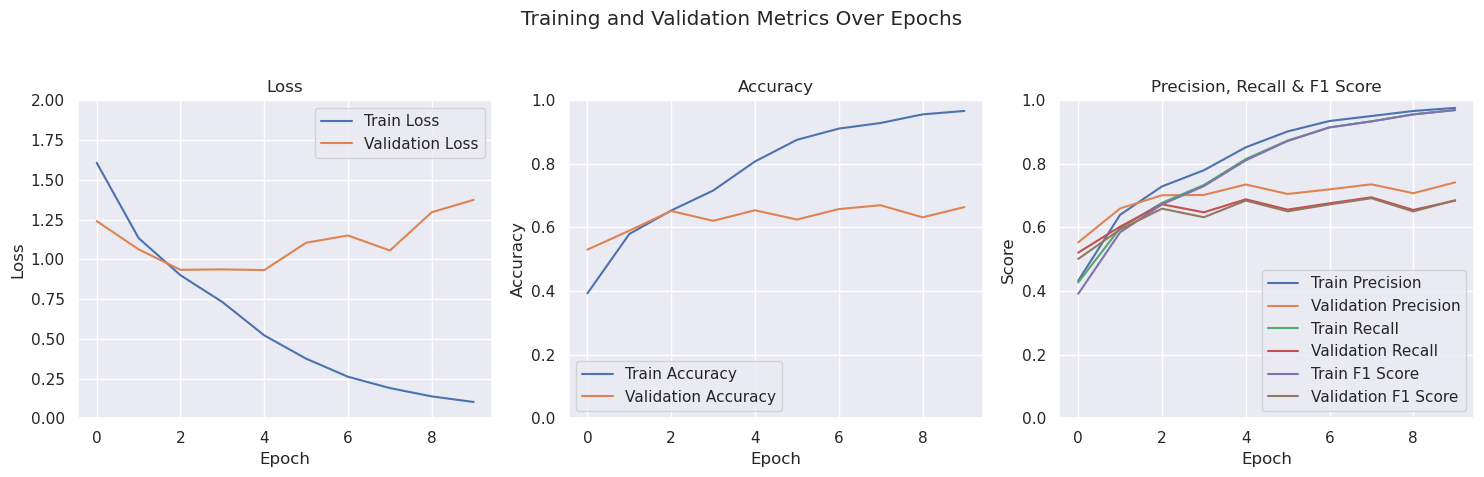

In [9]:
from torchvision import transforms
# Definiere die Transformationspipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Skaliere alle Bilder auf 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)
model = SimpleCNN(num_classes=9, lr=1e-3)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=10, logger_name="simple_CNN", callbacks=callbacks)

# InceptionWasteClassifier

In [10]:
from torchvision.models import inception_v3

class Inception_v3_WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = inception_v3(aux_logits=True, weights="Inception_V3_Weights.DEFAULT")
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        if self.training:
            outputs = self.model(x)
            return outputs.logits, outputs.aux_logits
        else:
            return self.model(x)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/Inception_v3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | Inception3          | 25.1 M
--------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.523   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.88046 (best 0.88046), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=0-val_loss=0.88.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.53224 (best 0.53224), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=1-val_loss=0.53.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.43049 (best 0.43049), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=2-val_loss=0.43.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.37683 (best 0.37683), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=3-val_loss=0.38.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.35018 (best 0.35018), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=4-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.35027 (best 0.35018), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=5-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' was not in top 2


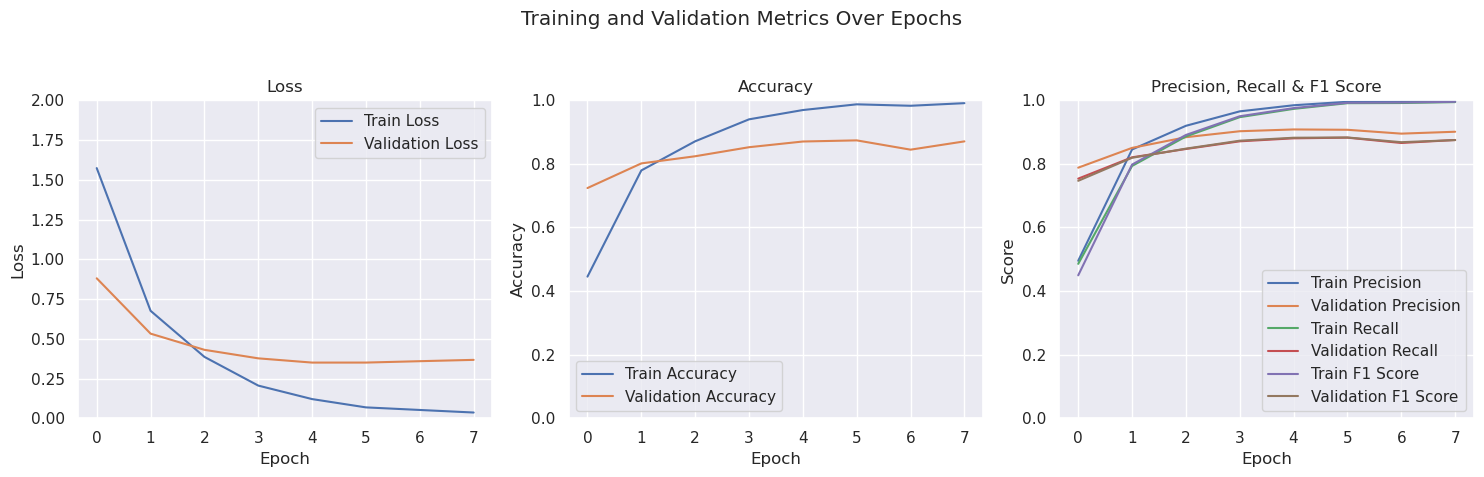

In [11]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(342, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
batch_size = 32
data_module = ConfigurableDataModule(data_path, batch_size, transform, workers=4) # setze auf 4 worker wegen ERROR: Nicht genug shared memory, durch multiprocessing

model = Inception_v3_WasteClassifier()
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="Inception_v3", callbacks=callbacks)

# DenseNetWasteClassifier

In [33]:
from torchvision.models import densenet121

class DenseNet201WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = densenet121(weights="DenseNet121_Weights.DEFAULT")
        self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [34]:
from torchvision.transforms.functional import InterpolationMode
# Define the transformations as per Inception V3's requirements
transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Felix/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 35.8MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs\densenet201
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | DenseNet            | 7.0 M 
--------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.852    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 119/119 [01:20<00:00,  1.49it/s, v_num=0, train_loss_step=0.496, train_acc_step=0.833, train_precision_step=0.882, train_recall_step=0.909, train_f1_step=0.884, val_inference_time=0.0357, val_loss=0.650, val_acc=0.773, val_precision=0.817, val_recall=0.778, val_f1=0.771, train_loss_epoch=1.200, train_acc_epoch=0.576, train_precision_epoch=0.644, train_recall_epoch=0.601, train_f1_epoch=0.585]

Epoch 0, global step 119: 'val_loss' reached 0.65028 (best 0.65028), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=0-val_loss=0.65.ckpt' as top 2


Epoch 1: 100%|██████████| 119/119 [01:51<00:00,  1.06it/s, v_num=0, train_loss_step=0.505, train_acc_step=0.845, train_precision_step=0.761, train_recall_step=0.773, train_f1_step=0.755, val_inference_time=0.018, val_loss=0.421, val_acc=0.868, val_precision=0.893, val_recall=0.870, val_f1=0.868, train_loss_epoch=0.466, train_acc_epoch=0.851, train_precision_epoch=0.893, train_recall_epoch=0.855, train_f1_epoch=0.857] 

Epoch 1, global step 238: 'val_loss' reached 0.42103 (best 0.42103), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=1-val_loss=0.42.ckpt' as top 2


Epoch 2: 100%|██████████| 119/119 [01:51<00:00,  1.07it/s, v_num=0, train_loss_step=0.211, train_acc_step=0.944, train_precision_step=0.970, train_recall_step=0.955, train_f1_step=0.952, val_inference_time=0.019, val_loss=0.355, val_acc=0.879, val_precision=0.901, val_recall=0.878, val_f1=0.878, train_loss_epoch=0.247, train_acc_epoch=0.929, train_precision_epoch=0.955, train_recall_epoch=0.935, train_f1_epoch=0.937]

Epoch 2, global step 357: 'val_loss' reached 0.35513 (best 0.35513), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=2-val_loss=0.36.ckpt' as top 2


Epoch 3: 100%|██████████| 119/119 [01:50<00:00,  1.08it/s, v_num=0, train_loss_step=0.200, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0184, val_loss=0.321, val_acc=0.891, val_precision=0.912, val_recall=0.893, val_f1=0.892, train_loss_epoch=0.157, train_acc_epoch=0.960, train_precision_epoch=0.978, train_recall_epoch=0.963, train_f1_epoch=0.966]

Epoch 3, global step 476: 'val_loss' reached 0.32099 (best 0.32099), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=3-val_loss=0.32.ckpt' as top 2


Epoch 4: 100%|██████████| 119/119 [01:50<00:00,  1.08it/s, v_num=0, train_loss_step=0.060, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0401, val_loss=0.324, val_acc=0.890, val_precision=0.917, val_recall=0.895, val_f1=0.894, train_loss_epoch=0.0849, train_acc_epoch=0.986, train_precision_epoch=0.993, train_recall_epoch=0.988, train_f1_epoch=0.989]

Epoch 4, global step 595: 'val_loss' reached 0.32381 (best 0.32099), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=4-val_loss=0.32.ckpt' as top 2


Epoch 5: 100%|██████████| 119/119 [01:54<00:00,  1.04it/s, v_num=0, train_loss_step=0.0579, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0182, val_loss=0.296, val_acc=0.902, val_precision=0.921, val_recall=0.903, val_f1=0.902, train_loss_epoch=0.0577, train_acc_epoch=0.989, train_precision_epoch=0.996, train_recall_epoch=0.991, train_f1_epoch=0.993]

Epoch 5, global step 714: 'val_loss' reached 0.29602 (best 0.29602), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=5-val_loss=0.30.ckpt' as top 2


Epoch 6: 100%|██████████| 119/119 [01:51<00:00,  1.06it/s, v_num=0, train_loss_step=0.0671, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0189, val_loss=0.296, val_acc=0.902, val_precision=0.923, val_recall=0.904, val_f1=0.903, train_loss_epoch=0.039, train_acc_epoch=0.992, train_precision_epoch=0.999, train_recall_epoch=0.997, train_f1_epoch=0.998] 

Epoch 6, global step 833: 'val_loss' reached 0.29594 (best 0.29594), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=6-val_loss=0.30.ckpt' as top 2


Epoch 7: 100%|██████████| 119/119 [01:54<00:00,  1.04it/s, v_num=0, train_loss_step=0.108, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0187, val_loss=0.295, val_acc=0.904, val_precision=0.922, val_recall=0.903, val_f1=0.902, train_loss_epoch=0.0262, train_acc_epoch=0.999, train_precision_epoch=0.999, train_recall_epoch=0.999, train_f1_epoch=0.999] 

Epoch 7, global step 952: 'val_loss' reached 0.29510 (best 0.29510), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=7-val_loss=0.30.ckpt' as top 2


Epoch 8: 100%|██████████| 119/119 [01:53<00:00,  1.05it/s, v_num=0, train_loss_step=0.0326, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0179, val_loss=0.296, val_acc=0.898, val_precision=0.920, val_recall=0.903, val_f1=0.901, train_loss_epoch=0.0222, train_acc_epoch=0.999, train_precision_epoch=1.000, train_recall_epoch=0.999, train_f1_epoch=0.999] 

Epoch 8, global step 1071: 'val_loss' reached 0.29573 (best 0.29510), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\DenseNet201WasteClassifier\\models\\epoch=8-val_loss=0.30.ckpt' as top 2


Epoch 9: 100%|██████████| 119/119 [01:54<00:00,  1.04it/s, v_num=0, train_loss_step=0.0154, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0185, val_loss=0.306, val_acc=0.906, val_precision=0.924, val_recall=0.906, val_f1=0.905, train_loss_epoch=0.0167, train_acc_epoch=0.997, train_precision_epoch=1.000, train_recall_epoch=0.999, train_f1_epoch=0.999] 

Epoch 9, global step 1190: 'val_loss' was not in top 2


Epoch 10: 100%|██████████| 119/119 [01:44<00:00,  1.14it/s, v_num=0, train_loss_step=0.0315, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0189, val_loss=0.297, val_acc=0.907, val_precision=0.928, val_recall=0.908, val_f1=0.908, train_loss_epoch=0.0134, train_acc_epoch=1.000, train_precision_epoch=1.000, train_recall_epoch=1.000, train_f1_epoch=1.000] 

Epoch 10, global step 1309: 'val_loss' was not in top 2


Epoch 11: 100%|██████████| 119/119 [01:48<00:00,  1.09it/s, v_num=0, train_loss_step=0.0183, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0181, val_loss=0.307, val_acc=0.911, val_precision=0.929, val_recall=0.910, val_f1=0.909, train_loss_epoch=0.012, train_acc_epoch=1.000, train_precision_epoch=1.000, train_recall_epoch=1.000, train_f1_epoch=1.000]  

Epoch 11, global step 1428: 'val_loss' was not in top 2


Epoch 12: 100%|██████████| 119/119 [01:50<00:00,  1.08it/s, v_num=0, train_loss_step=0.00809, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0289, val_loss=0.313, val_acc=0.901, val_precision=0.925, val_recall=0.904, val_f1=0.904, train_loss_epoch=0.00943, train_acc_epoch=1.000, train_precision_epoch=1.000, train_recall_epoch=1.000, train_f1_epoch=1.000]

Epoch 12, global step 1547: 'val_loss' was not in top 2


Epoch 13:  95%|█████████▍| 113/119 [01:04<00:03,  1.75it/s, v_num=0, train_loss_step=0.00435, train_acc_step=1.000, train_precision_step=1.000, train_recall_step=1.000, train_f1_step=1.000, val_inference_time=0.0289, val_loss=0.313, val_acc=0.901, val_precision=0.925, val_recall=0.904, val_f1=0.904, train_loss_epoch=0.00943, train_acc_epoch=1.000, train_precision_epoch=1.000, train_recall_epoch=1.000, train_f1_epoch=1.000]

c:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


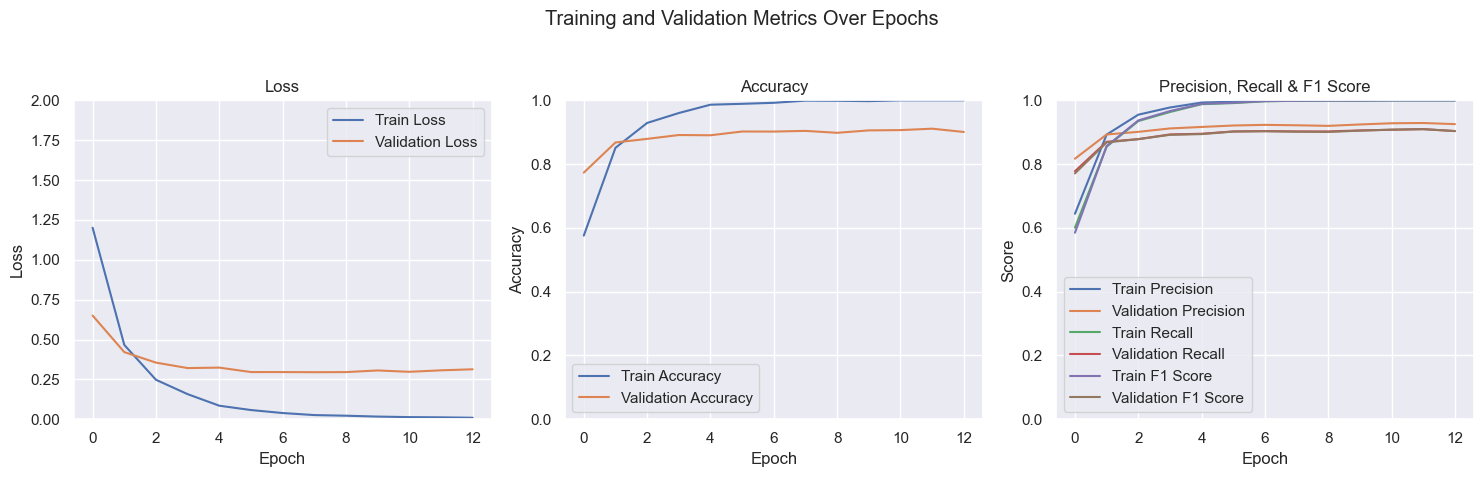

In [35]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = DenseNet201WasteClassifier(num_classes=9)

callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)

train_model(model, data_module, max_epochs=50, logger_name="densenet201", callbacks=callbacks)



# Resnet50

In [15]:
from torchvision.models import resnet50

class ResNet50WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = resnet50(weights="ResNet50_Weights.DEFAULT")
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [16]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/resnet50
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | ResNet              | 23.5 M
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 1.23184 (best 1.23184), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=0-val_loss=1.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.66244 (best 0.66244), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=1-val_loss=0.66.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.48616 (best 0.48616), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=2-val_loss=0.49.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.40051 (best 0.40051), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=3-val_loss=0.40.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.35182 (best 0.35182), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=4-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.32204 (best 0.32204), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=5-val_loss=0.32.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' reached 0.29817 (best 0.29817), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=6-val_loss=0.30.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' reached 0.28388 (best 0.28388), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=7-val_loss=0.28.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1071: 'val_loss' reached 0.29228 (best 0.28388), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=8-val_loss=0.29.ckpt' as top 2


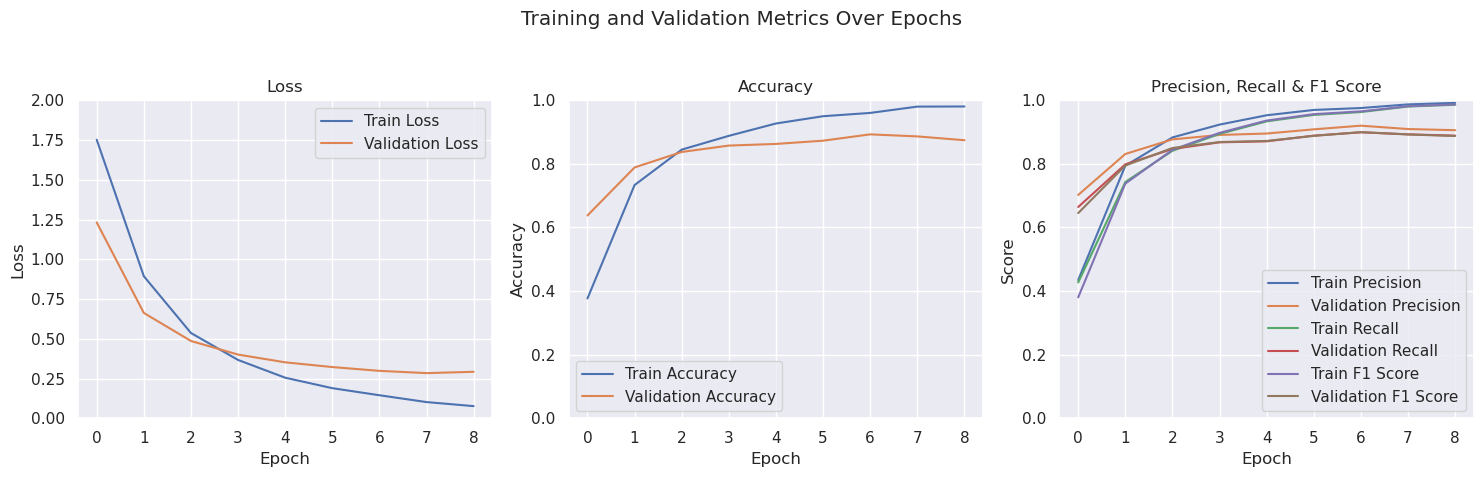

In [17]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = ResNet50WasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="resnet50", callbacks=callbacks)


# VGG16

In [18]:
from torchvision.models import vgg16

class VGG16WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = vgg16(weights="VGG16_Weights.DEFAULT")
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [19]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/vgg16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | VGG                 | 134 M 
--------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.190   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.64266 (best 0.64266), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=0-val_loss=0.64.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.42639 (best 0.42639), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=1-val_loss=0.43.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.35679 (best 0.35679), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=2-val_loss=0.36.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.39097 (best 0.35679), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=4-val_loss=0.39.ckpt' as top 2


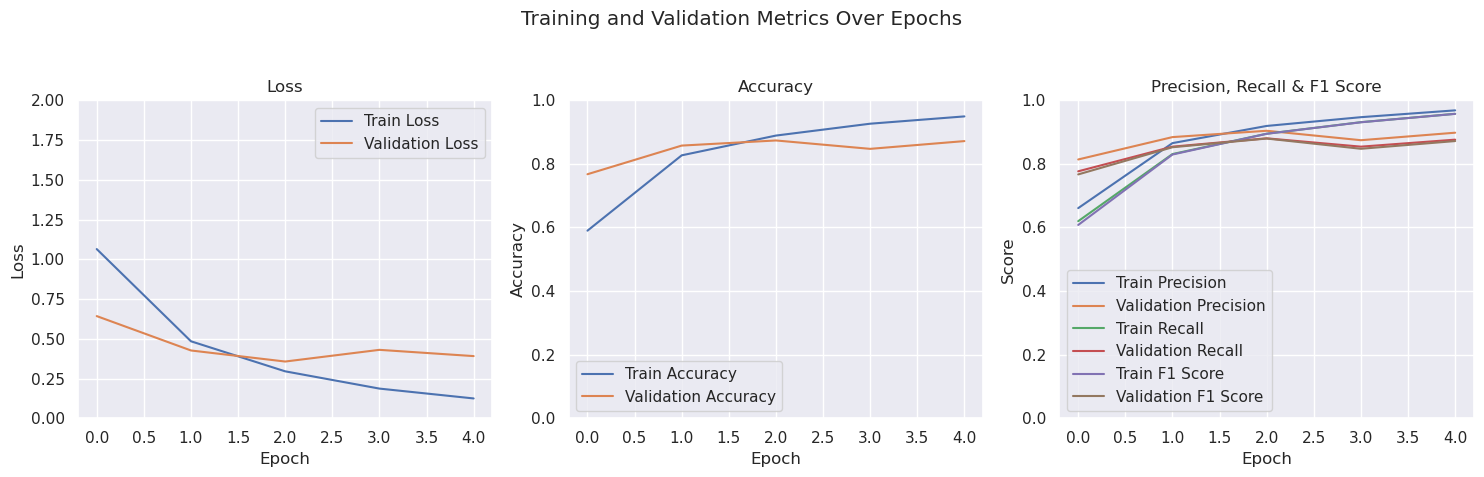

In [20]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = VGG16WasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="vgg16", callbacks=callbacks)


# Vision Transformer

In [21]:
from torchvision.models import vit_l_16

class VitWasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = vit_l_16(weights="ViT_L_16_Weights.DEFAULT")
        in_features = self.model.heads.head.in_features
        self.model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)

    def forward(self, x):
        return self.model(x)

In [22]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(242, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/ViT-l-16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | VisionTransformer   | 303 M 
--------------------------------------------------
303 M     Trainable params
0         Non-trainable params
303 M     Total params
1,213.243 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.43806 (best 0.43806), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=0-val_loss=0.44.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.32643 (best 0.32643), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=1-val_loss=0.33.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.24784 (best 0.24784), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=2-val_loss=0.25.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.22726 (best 0.22726), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=3-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.23015 (best 0.22726), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=4-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' was not in top 2


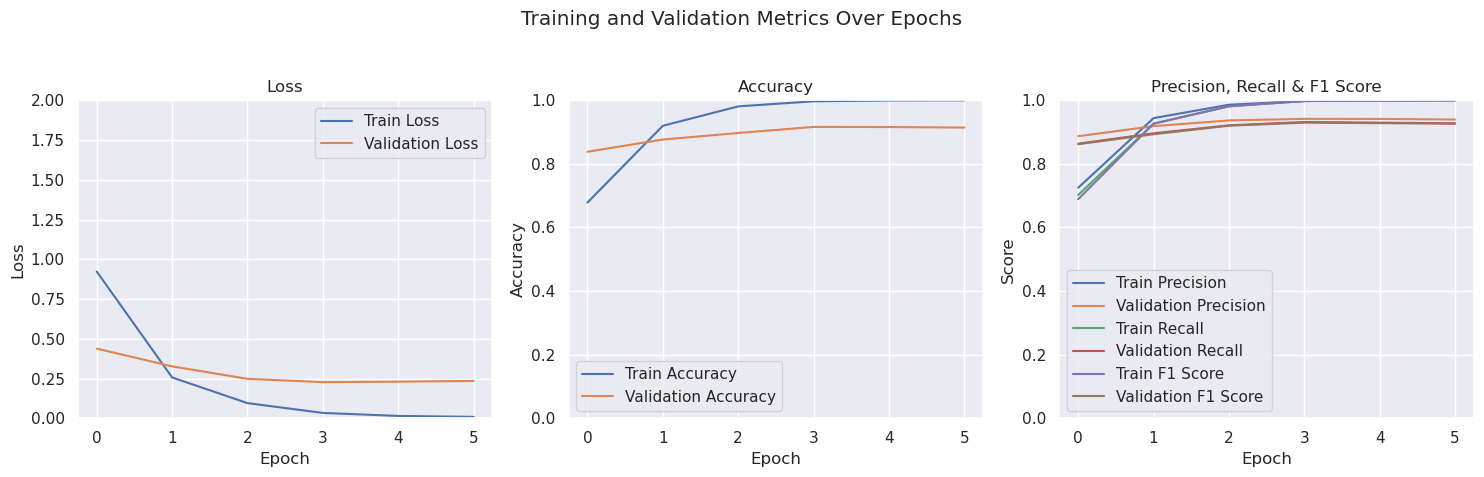

In [23]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = VitWasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="ViT-l-16", callbacks=callbacks)

# AlexNet

In [27]:
from torchvision.models import alexnet

class AlexNetWasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = alexnet(weights="AlexNet_Weights.DEFAULT")
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [28]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Felix/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 32.8MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs\AlexNet
c:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\Felix\Desktop\RealWaste\results\AlexNetWasteClassifier\models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | AlexNet             | 57.0 M
----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\Felix\anaconda3\envs\cudatest\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 119/119 [00:57<00:00,  2.07it/s, v_num=0_1, train_loss_step=0.753, train_acc_step=0.611, train_precision_step=0.666, train_recall_step=0.682, train_f1_step=0.658, val_inference_time=0.00739, val_loss=0.742, val_acc=0.695, val_precision=0.767, val_recall=0.715, val_f1=0.709, train_loss_epoch=1.020, train_acc_epoch=0.621, train_precision_epoch=0.678, train_recall_epoch=0.636, train_f1_epoch=0.625]

Epoch 0, global step 119: 'val_loss' reached 0.74221 (best 0.74221), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\AlexNetWasteClassifier\\models\\epoch=0-val_loss=0.74.ckpt' as top 2


Epoch 1: 100%|██████████| 119/119 [01:34<00:00,  1.26it/s, v_num=0_1, train_loss_step=1.070, train_acc_step=0.742, train_precision_step=0.640, train_recall_step=0.591, train_f1_step=0.580, val_inference_time=0.00134, val_loss=0.601, val_acc=0.791, val_precision=0.836, val_recall=0.797, val_f1=0.796, train_loss_epoch=0.543, train_acc_epoch=0.800, train_precision_epoch=0.843, train_recall_epoch=0.807, train_f1_epoch=0.805]

Epoch 1, global step 238: 'val_loss' reached 0.60108 (best 0.60108), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\AlexNetWasteClassifier\\models\\epoch=1-val_loss=0.60.ckpt' as top 2


Epoch 2: 100%|██████████| 119/119 [01:33<00:00,  1.27it/s, v_num=0_1, train_loss_step=0.877, train_acc_step=0.861, train_precision_step=0.818, train_recall_step=0.818, train_f1_step=0.818, val_inference_time=0.0013, val_loss=0.509, val_acc=0.830, val_precision=0.856, val_recall=0.826, val_f1=0.825, train_loss_epoch=0.345, train_acc_epoch=0.877, train_precision_epoch=0.905, train_recall_epoch=0.881, train_f1_epoch=0.880] 

Epoch 2, global step 357: 'val_loss' reached 0.50922 (best 0.50922), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\AlexNetWasteClassifier\\models\\epoch=2-val_loss=0.51.ckpt' as top 2


Epoch 3: 100%|██████████| 119/119 [01:25<00:00,  1.39it/s, v_num=0_1, train_loss_step=0.662, train_acc_step=0.800, train_precision_step=0.824, train_recall_step=0.773, train_f1_step=0.770, val_inference_time=0.00137, val_loss=0.534, val_acc=0.810, val_precision=0.856, val_recall=0.820, val_f1=0.817, train_loss_epoch=0.235, train_acc_epoch=0.924, train_precision_epoch=0.941, train_recall_epoch=0.924, train_f1_epoch=0.924]

Epoch 3, global step 476: 'val_loss' reached 0.53433 (best 0.50922), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\AlexNetWasteClassifier\\models\\epoch=3-val_loss=0.53.ckpt' as top 2


Epoch 4: 100%|██████████| 119/119 [01:31<00:00,  1.29it/s, v_num=0_1, train_loss_step=0.205, train_acc_step=0.950, train_precision_step=0.924, train_recall_step=0.909, train_f1_step=0.910, val_inference_time=0.0054, val_loss=0.534, val_acc=0.824, val_precision=0.860, val_recall=0.827, val_f1=0.825, train_loss_epoch=0.157, train_acc_epoch=0.942, train_precision_epoch=0.957, train_recall_epoch=0.945, train_f1_epoch=0.944]  

Epoch 4, global step 595: 'val_loss' reached 0.53351 (best 0.50922), saving model to 'C:\\Users\\Felix\\Desktop\\RealWaste\\results\\AlexNetWasteClassifier\\models\\epoch=4-val_loss=0.53.ckpt' as top 2


Epoch 4: 100%|██████████| 119/119 [01:33<00:00,  1.28it/s, v_num=0_1, train_loss_step=0.205, train_acc_step=0.950, train_precision_step=0.924, train_recall_step=0.909, train_f1_step=0.910, val_inference_time=0.0054, val_loss=0.534, val_acc=0.824, val_precision=0.860, val_recall=0.827, val_f1=0.825, train_loss_epoch=0.157, train_acc_epoch=0.942, train_precision_epoch=0.957, train_recall_epoch=0.945, train_f1_epoch=0.944]


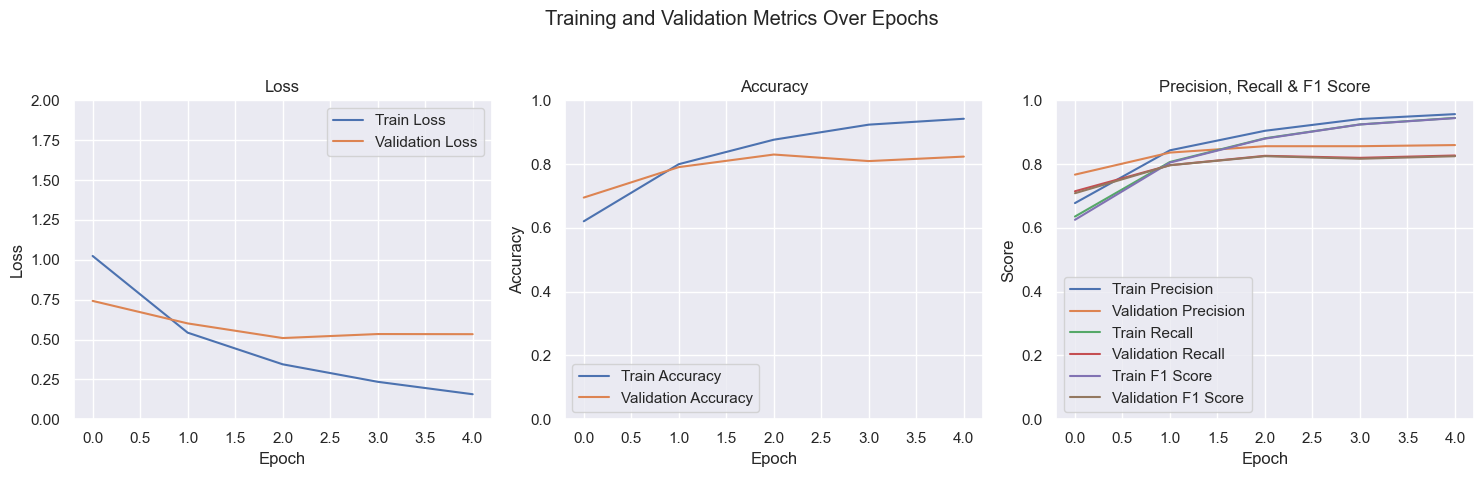

In [29]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = AlexNetWasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="AlexNet", callbacks=callbacks)